This notebook describes how to build, train and analyse the neural network for SASE pulses classification. It also contains many useful tool for neural networks in general.

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import argparse
import os
import random as rn
import matplotlib.pyplot as plt
import time


NB_CHANNELS = 16
NB_LABELS = 5
n = 3 # (Number of quantization bits)

Helper Functions

In [2]:
def use_gpu(Flag):
# (0 = GPU, -1 = CPU)    
    os.environ['CUDA_VISIBLE_DEVICES'] = Flag  
    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    return

    
def doWeights(model):

    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')

def get_dense_layer_weights(model):
    w = []
    b = []
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        w.append(layer.get_weights()[0])
        b.append(layer.get_weights()[1])

    return w, b   

Setup

In [3]:
# Seed Setup
seed_value = 1
keras_kernel_initializer = 'lecun_uniform'
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Selecting CPU or GPU     
use_gpu('-1')  # ('0' = GPU, '-1' = CPU) (for small fc nn, cpu is faster)     

No GPU found


Loading Dataset

In [4]:
# test set
X_test = np.load('../dataset/test_set_' + str(n) + 'bits_opt.npz')['X_test']
Y_test = np.load('../dataset/test_set_' + str(n) + 'bits_opt.npz')['Y_test']

print(X_test.shape)
print(Y_test.shape)

(100000, 16, 8, 1)
(100000,)


# Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation, Input, Flatten, Dense, ReLU, Softmax
from tensorflow import keras


input_shape = (NB_CHANNELS,2**n,1)

model = Sequential(name='fc')
model.add(Input(shape=input_shape))
model.add(Flatten())

model.add(Dense(4, name='fc1',kernel_initializer='lecun_uniform'))
model.add(ReLU(name='relu1', max_value=4, negative_slope=0.0, threshold=0.0))

model.add(Dense(32, name='fc2',
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(ReLU(name='relu2', max_value=4, negative_slope=0.0, threshold=0.0))

model.add(Dense(32, name='fc3',
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(ReLU(name='relu3', max_value=4, negative_slope=0.0, threshold=0.0))

model.add(Dense(NB_LABELS, name='output',
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Softmax(name='output_softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 4)                 516       
_________________________________________________________________
relu1 (ReLU)                 (None, 4)                 0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                160       
_________________________________________________________________
relu2 (ReLU)                 (None, 32)                0         
_________________________________________________________________
fc3 (Dense)                  (None, 32)                1056      
_________________________________________________________________
relu3 (ReLU)                 (None, 32)                0        

# Training

In [ ]:
history = model.fit(X_test, Y_test, batch_size=512, epochs=10, validation_split=0.2, shuffle=True)

training_loss = history.history['loss']
training_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Training visualisation

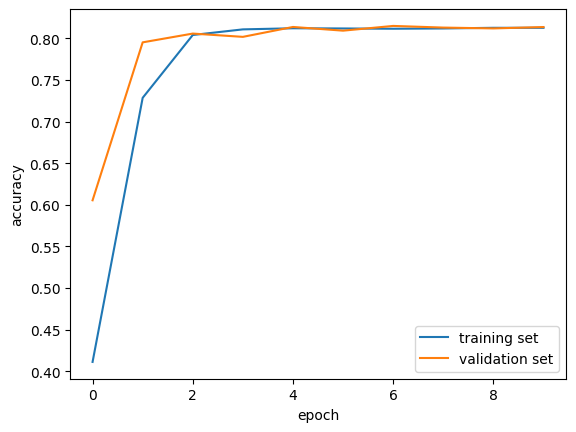

In [ ]:
plt.plot(training_acc,label='training set')
plt.plot(val_acc, label='validation set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Model analysis

Extracting weights

In [ ]:
w, b = get_dense_layer_weights(model)

w[0].shape    # this is the weights from the first dense layer


(128, 4)

Visualizing weights

Layer fc1: % of zeros = 0.0
Layer fc2: % of zeros = 0.0
Layer fc3: % of zeros = 0.0
Layer output: % of zeros = 0.0


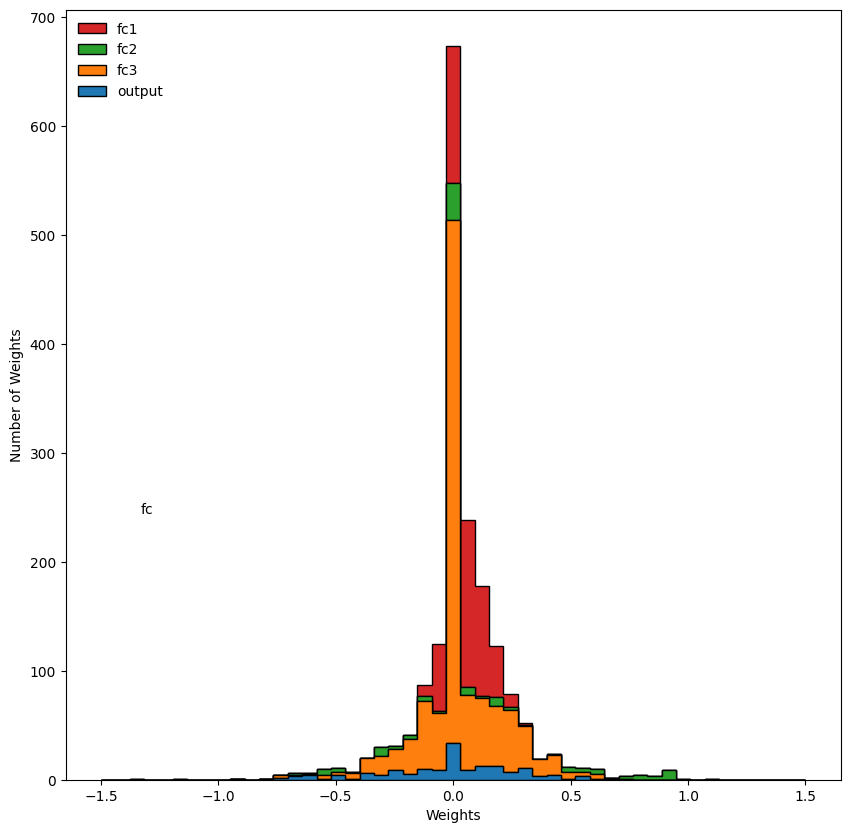

In [ ]:
doWeights(model)

Output from intermediate layer

In [ ]:
extractor = keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
features = extractor(X_test[0:3])   # testing with the 3 first images

features[1][0].numpy()  # this is the output from the first dense layer with the first test image


 * MIT License
 *
 * Copyright (c) 2022 SLAC National Accelerator Laboratory
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in all
 * copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
 * SOFTWARE.
 *
 * Authors : Berthié Gouin-Ferland
 * Last update : 2022-12-08
 *
 * Description : This notebook describes how to build, train and analyse the neural network for SASE pulses classification. It also contains many useful tool for neural networks in general.
